# Regressão Softmax com dados do MNIST utilizando gradiente descendente estocástico por minibatches

O objetivo deste notebook é ilustrar
- o uso do gradiente estocástico por mini-batchs
- utilizando as classes Dataset e DataLoater.

A apresentação da perda nos gráficos é um pouco diferente da usual, mostrando a perda de cada um dos vários minibatches dentro de cada época, de forma que as épocas são apresentadas com valores fracionários.

## Importação das bibliotecas

In [53]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import MNIST

## Dataset e dataloader

### Definição do tamanho do minibatch

In [54]:
#Batches com 100 amostras cada
batch_size = 100

### Carregamento, criação dataset e do dataloader

In [55]:
dataset_dir = 'MNIST/'

dataset_train = MNIST(dataset_dir, train=True, download=True,
                      transform=torchvision.transforms.ToTensor())

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)


print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 600

Dimensões dos dados de um minibatch: torch.Size([100, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


### Usando todas as amostras do MNIST

Neste exemplo utilizaremos todas as amostras de treinamento.

In [56]:
print('Número de minibatches de trenamento:', len(loader_train))
n_batches_train = len(loader_train)
total_samples = dataset_train.train_data.size(0)

Número de minibatches de trenamento: 600


/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [57]:
dataset_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [58]:
#Matriz de 28x28 pixels
dataset_train.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

## Modelo

In [59]:
#Criação de uma camada linear com 784 entradas e 10 saídas
model = torch.nn.Linear(28*28, 10)

In [60]:
#Pesos e bias inicializados no modelo
model.state_dict()

OrderedDict([('weight',
              tensor([[ 0.0239, -0.0248,  0.0301,  ...,  0.0310,  0.0334,  0.0058],
                      [-0.0031,  0.0087,  0.0115,  ...,  0.0063, -0.0010,  0.0250],
                      [ 0.0156,  0.0106,  0.0243,  ...,  0.0095, -0.0181, -0.0280],
                      ...,
                      [ 0.0346, -0.0310, -0.0169,  ..., -0.0234,  0.0027,  0.0281],
                      [-0.0236, -0.0267,  0.0101,  ..., -0.0189,  0.0135, -0.0188],
                      [-0.0357,  0.0187,  0.0037,  ...,  0.0086,  0.0029,  0.0318]])),
             ('bias',
              tensor([-0.0057, -0.0342, -0.0259, -0.0031, -0.0087,  0.0011,  0.0222,  0.0275,
                      -0.0276,  0.0107]))])

In [61]:
# Estrutura dos pesos
model.weight.shape

torch.Size([10, 784])

In [62]:
# Pesos associados a o primeiro valor de saída (imagem 0, por exemplo)
model.weight[0]

tensor([ 2.3860e-02, -2.4838e-02,  3.0137e-02, -5.7457e-03, -1.2776e-02,
         1.5854e-02, -2.2523e-04,  2.0702e-03, -3.2555e-02, -1.3679e-03,
        -7.5700e-03,  2.6172e-02,  1.9699e-02,  2.8698e-02, -1.7056e-02,
        -3.0228e-02,  2.4675e-02,  6.9603e-03, -1.8251e-02, -6.2554e-03,
        -8.1737e-03,  4.0366e-04,  5.3185e-03, -1.3665e-02,  1.5491e-02,
         2.2822e-02, -2.8782e-02,  9.2522e-03,  1.1422e-02, -2.3218e-02,
         3.5019e-02, -3.4045e-02, -2.3047e-02, -3.0280e-02,  1.4203e-02,
        -3.3994e-02,  2.6722e-02,  9.3662e-03, -1.8742e-02,  2.8057e-02,
        -1.7139e-02,  1.2272e-02, -1.4008e-02,  3.2204e-02, -6.2596e-03,
        -9.5266e-03,  2.4007e-02,  1.1411e-02,  2.5960e-02, -1.7769e-02,
        -5.0362e-03,  2.1172e-02, -1.2901e-02,  3.2776e-03,  3.3917e-02,
        -1.7943e-02, -3.3507e-02,  2.5454e-02,  2.7375e-02, -2.4315e-03,
         5.6651e-03,  1.3614e-02, -2.8635e-02, -3.0834e-02, -1.0828e-02,
         2.5976e-02, -8.5811e-04, -3.5902e-03, -2.7

In [63]:
#Soma dos pesos (Considerando uma entrada com x =1 em todos os valores )
model.weight[0].sum()

tensor(-0.2695, grad_fn=<SumBackward0>)

In [64]:
# Bias do modelo
model.bias

Parameter containing:
tensor([-0.0057, -0.0342, -0.0259, -0.0031, -0.0087,  0.0011,  0.0222,  0.0275,
        -0.0276,  0.0107], requires_grad=True)

In [65]:
model.bias[0]

tensor(-0.0057, grad_fn=<SelectBackward0>)

In [66]:
#Cálculo manual do valor previsto para a primeira saída
model.weight[0].sum() + model.bias[0]

tensor(-0.2752, grad_fn=<AddBackward0>)

In [67]:
#Predict para testar (sem treinamento)

#Valor x de entrada como uma matriz 28x28 com todos os valores 1
x = torch.ones(28*28).reshape(1, 784)
print(x.shape)
predict = model(x)
predict

torch.Size([1, 784])


tensor([[-0.2752,  0.2942, -0.0518,  0.4144,  0.4856, -0.6057, -0.4568, -0.8716,
         -0.5191,  1.4383]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [68]:
n_epochs = 5
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Laço de treinamento dos parâmetros

In [69]:
epochs100 = []
losses100 = []
loss_end_epoch=[]
x=0

total_trained_samples = 0
for i in range(n_epochs):
    for k,(x_train, y_train) in enumerate(loader_train):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # predict da rede
        outputs = model(inputs)

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs100.append(total_trained_samples / total_samples)
        losses100.append(loss.data)

        #Imprimir o valor da perda ao final de cada época de treinamento (cada época com será treinada com 600 minibatches)
        if k == 599:
          x+=1
          print(f' Perda: {loss.data}')
          print(f'Época: {x}/5, batch= {len(loader_train)} ')




 Perda: 0.2766750156879425
Época: 1/5, batch= 600 
 Perda: 0.4217778444290161
Época: 2/5, batch= 600 
 Perda: 0.2537011206150055
Época: 3/5, batch= 600 
 Perda: 0.27106839418411255
Época: 4/5, batch= 600 
 Perda: 0.2909916937351227
Época: 5/5, batch= 600 


In [70]:
print('Final loss:', loss.data)

Final loss: tensor(0.2910)


### Visualizando gráfico de perda durante o treinamento e ao final de cada época

In [71]:
epochs100[599::600]

[1.0, 2.0, 3.0, 4.0, 5.0]

In [72]:
losses100[599::600]

[tensor(0.2767),
 tensor(0.4218),
 tensor(0.2537),
 tensor(0.2711),
 tensor(0.2910)]

Text(0.5, 1.0, 'Evolução da perda por minibatch e por época (batchsize=100)')

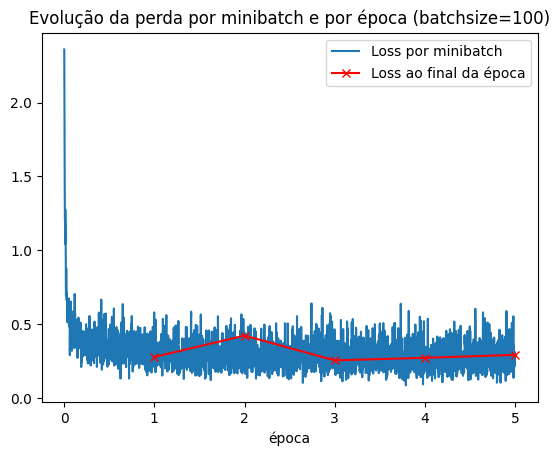

In [73]:
plt.plot(epochs100, losses100)
plt.xlabel('época')

plt.plot(epochs100[599::600], losses100[599::600], color='r',marker='x')
plt.xlabel('época')
plt.legend(['Loss por minibatch','Loss ao final da época'])
plt.title('Evolução da perda por minibatch e por época (batchsize=100)')

# Atividades

## Perguntas

1. Qual é o tamanho do mini-batch?
**100**
2. Em uma época, quantos mini-batches existem?
**600 (60000/100)**
3. Qual é a definição de época?
**Um laço de treinamento onde todos os dados presentes nos minibatches passam pelo predict, cálculo da perda, cálculo do gradiente e atualização dos pesos**

## Exercícios


1. Coloque um print no final de cada minibatch, no mesmo estilo do print do final de época, no seguinte estilo:
    - Época: 1/4, batch: 600

  **Realizado no código acima (Seção: Laço de treinamento de parâmetros)**

  2. Altere o tamanho de minibatch (batch_size) algumas vezes, refaça o treinamento, e compare no gráfico abaixo a queda da perda para cada tamanho de minibatch.




### Exercício 2 batch size = 50

##### Definição do tamanho do minibatch

In [74]:
batch_size = 50

##### Carregamento, criação dataset e do dataloader

In [75]:
dataset_dir = 'MNIST/'

dataset_train = MNIST(dataset_dir, train=True, download=True,
                      transform=torchvision.transforms.ToTensor())

loader_train50 = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)


print('Número de minibatches de trenamento:', len(loader_train50))

x_train, y_train = next(iter(loader_train50))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 1200

Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


In [76]:
print('Número de minibatches de trenamento:', len(loader_train50))
n_batches_train = len(loader_train50)
total_samples = dataset_train.train_data.size(0)

Número de minibatches de trenamento: 1200


#####Criação do modelo

In [77]:
#Criação de uma camada linear com 784 entradas e 10 saídas
model = torch.nn.Linear(28*28, 10)

##### Inicialização dos parâmetros

In [78]:
n_epochs = 5
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

##### Laço de treinamento dos parâmetros

In [79]:
epochs50 = []
losses50 = []
loss_end_epoch=[]
x=0

total_trained_samples = 0
for i in range(n_epochs):
    for k,(x_train, y_train) in enumerate(loader_train50):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # predict da rede
        outputs = model(inputs)

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs50.append(total_trained_samples / total_samples)
        losses50.append(loss.data)

        if k == (len(loader_train50)-1):
          x+=1
          print(f' Perda: {loss.data}')
          print(f'Época: {x}/5, batch= {len(loader_train50)} ')




 Perda: 0.29876551032066345
Época: 1/5, batch= 1200 
 Perda: 0.11087996512651443
Época: 2/5, batch= 1200 
 Perda: 0.3651593029499054
Época: 3/5, batch= 1200 
 Perda: 0.26055729389190674
Época: 4/5, batch= 1200 
 Perda: 0.133952334523201
Época: 5/5, batch= 1200 


In [80]:
print('Final loss:', loss.data)

Final loss: tensor(0.1340)


##### Visualizando gráfico de perda durante o treinamento e ao final de cada época

Text(0.5, 1.0, 'Evolução da perda por minibatch e por época (batchsize=50)')

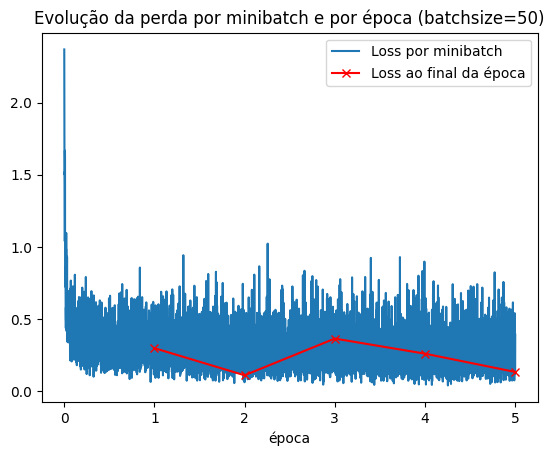

In [81]:
plt.plot(epochs50, losses50)
plt.xlabel('época')

plt.plot(epochs50[len(loader_train50)-1::len(loader_train50)], losses50[len(loader_train50)-1::len(loader_train50)], color='r',marker='x')
plt.xlabel('época')
plt.legend(['Loss por minibatch','Loss ao final da época'])
plt.title('Evolução da perda por minibatch e por época (batchsize=50)')

###Exercício 2 batch size=200

##### Definição do tamanho do minibatch

In [82]:
batch_size = 200

##### Carregamento, criação dataset e do dataloader

In [83]:
dataset_dir = 'MNIST/'

dataset_train = MNIST(dataset_dir, train=True, download=True,
                      transform=torchvision.transforms.ToTensor())

loader_train200 = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)


print('Número de minibatches de trenamento:', len(loader_train200))

x_train, y_train = next(iter(loader_train200))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 300

Dimensões dos dados de um minibatch: torch.Size([200, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


In [84]:
print('Número de minibatches de trenamento:', len(loader_train200))
n_batches_train = len(loader_train200)
total_samples = dataset_train.train_data.size(0)

Número de minibatches de trenamento: 300


#####Criação do modelo

In [85]:
#Criação de uma camada linear com 784 entradas e 10 saídas
model = torch.nn.Linear(28*28, 10)

##### Inicialização dos parâmetros

In [86]:
n_epochs = 5
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

##### Laço de treinamento dos parâmetros

In [87]:
epochs200 = []
losses200 = []
loss_end_epoch=[]
x=0

total_trained_samples = 0
for i in range(n_epochs):
    for k,(x_train, y_train) in enumerate(loader_train200):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # predict da rede
        outputs = model(inputs)

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs200.append(total_trained_samples / total_samples)
        losses200.append(loss.data)

        if k == (len(loader_train200)-1):
          x+=1
          print(f' Perda: {loss.data}')
          print(f'Época: {x}/5, batch= {len(loader_train200)} ')




 Perda: 0.21902260184288025
Época: 1/5, batch= 300 
 Perda: 0.24996688961982727
Época: 2/5, batch= 300 
 Perda: 0.2603747546672821
Época: 3/5, batch= 300 
 Perda: 0.2907443940639496
Época: 4/5, batch= 300 
 Perda: 0.48327431082725525
Época: 5/5, batch= 300 


In [88]:
print('Final loss:', loss.data)

Final loss: tensor(0.4833)


##### Visualizando gráfico de perda durante o treinamento e ao final de cada época

Text(0.5, 1.0, 'Evolução da perda por minibatch e por época (batchsize=200)')

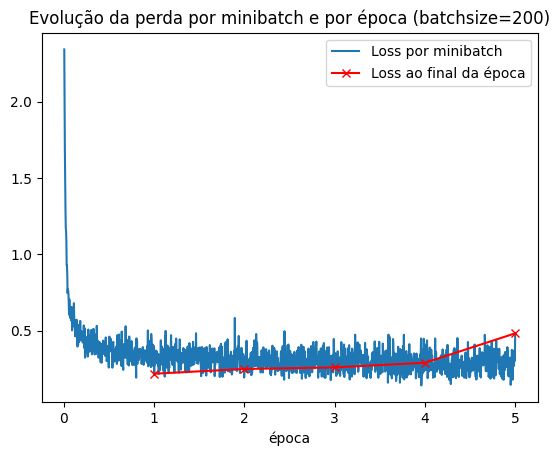

In [89]:
plt.plot(epochs200, losses200)
plt.xlabel('época')

plt.plot(epochs200[len(loader_train200)-1::len(loader_train200)], losses200[len(loader_train200)-1::len(loader_train200)], color='r',marker='x')
plt.xlabel('época')
plt.legend(['Loss por minibatch','Loss ao final da época'])

plt.title('Evolução da perda por minibatch e por época (batchsize=200)')

###Exercício 2 batch size = 300

##### Definição do tamanho do minibatch

In [90]:
batch_size = 300

##### Carregamento, criação dataset e do dataloader

In [91]:
dataset_dir = 'MNIST/'

dataset_train = MNIST(dataset_dir, train=True, download=True,
                      transform=torchvision.transforms.ToTensor())

loader_train300 = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)


print('Número de minibatches de trenamento:', len(loader_train300))

x_train, y_train = next(iter(loader_train300))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 200

Dimensões dos dados de um minibatch: torch.Size([300, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


In [92]:
print('Número de minibatches de trenamento:', len(loader_train300))
n_batches_train = len(loader_train300)
total_samples = dataset_train.train_data.size(0)

Número de minibatches de trenamento: 200


#####Criação do modelo

In [93]:
#Criação de uma camada linear com 784 entradas e 10 saídas
model = torch.nn.Linear(28*28, 10)

##### Inicialização dos parâmetros

In [94]:
n_epochs = 5
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

##### Laço de treinamento dos parâmetros

In [95]:
epochs300 = []
losses300 = []
loss_end_epoch=[]
x=0

total_trained_samples = 0
for i in range(n_epochs):
    for k,(x_train, y_train) in enumerate(loader_train300):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # predict da rede
        outputs = model(inputs)

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs300.append(total_trained_samples / total_samples)
        losses300.append(loss.data)

        if k == (len(loader_train)-1):
          x+=1
          print(f' Perda: {loss.data}')
          print(f'Época: {x}/5, batch= {len(loader_train300)} ')




In [96]:
print('Final loss:', loss.data)

Final loss: tensor(0.3386)


##### Visualizando gráfico de perda durante o treinamento e ao final de cada época

Text(0.5, 1.0, 'Evolução da perda por minibatch e por época (batchsize=300)')

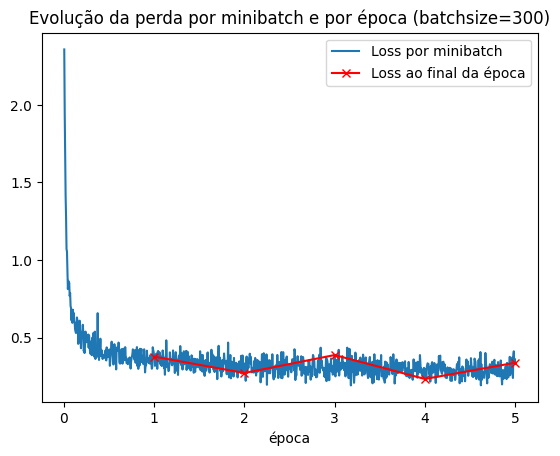

In [97]:
plt.plot(epochs300, losses300)
plt.xlabel('época')

plt.plot(epochs300[len(loader_train300)-1::len(loader_train300)], losses300[len(loader_train300)-1::len(loader_train300)], color='r',marker='x')
plt.xlabel('época')
plt.legend(['Loss por minibatch','Loss ao final da época'])
plt.title('Evolução da perda por minibatch e por época (batchsize=300)')

##Exercício 2 - Comparativo dos gráficos

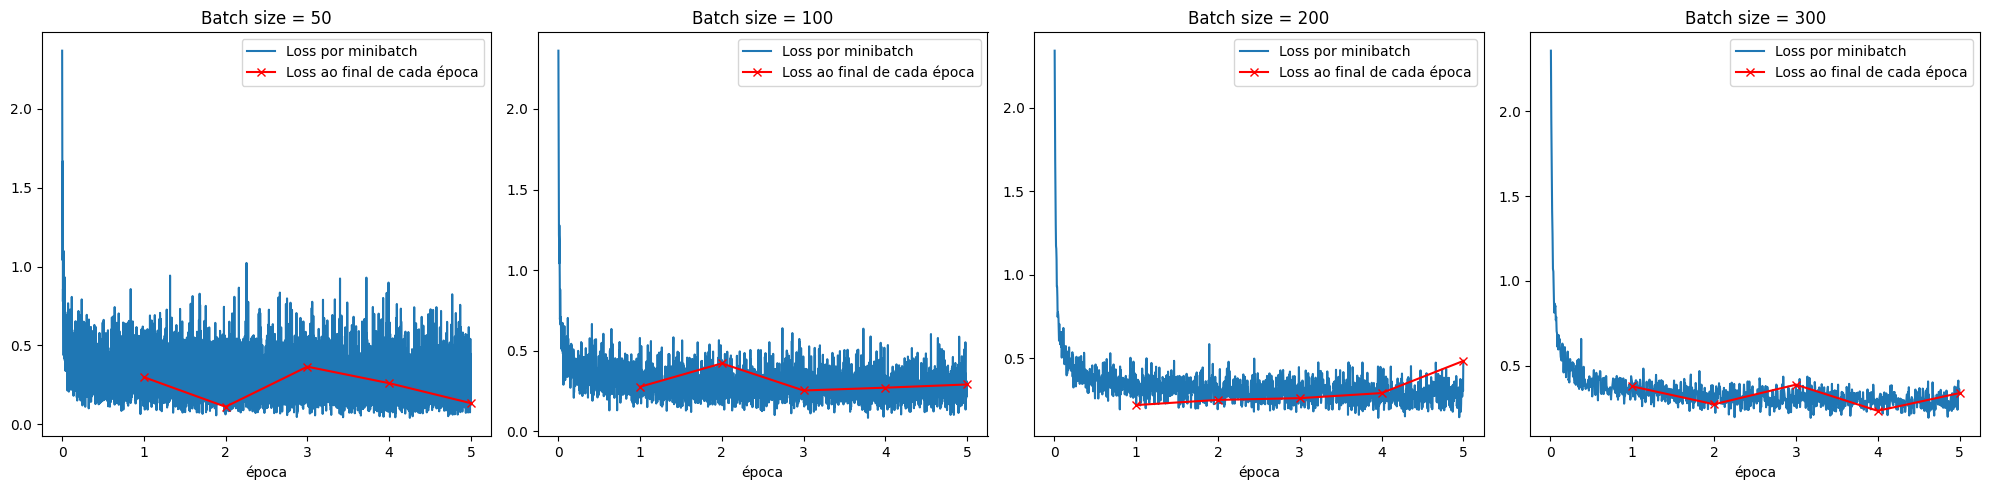

In [98]:
fig, ax = plt.subplots(1,4, tight_layout=True, figsize=(20,5))

ax[0].set_title('Batch size = 50')
ax[0].plot(epochs50, losses50)
ax[0].set_xlabel('época')

ax[0].plot(epochs50[len(loader_train50)-1::len(loader_train50)], losses50[len(loader_train50)-1::len(loader_train50)], color='r',marker='x')
ax[0].set_xlabel('época')
ax[0].legend(['Loss por minibatch','Loss ao final de cada época'])

ax[1].set_title('Batch size = 100')
ax[1].plot(epochs100, losses100)
ax[1].set_xlabel('época')

ax[1].plot(epochs100[len(loader_train)-1::len(loader_train)], losses100[len(loader_train)-1::len(loader_train)], color='r',marker='x')
ax[1].set_xlabel('época')
ax[1].legend(['Loss por minibatch','Loss ao final de cada época'])

ax[2].set_title('Batch size = 200')
ax[2].plot(epochs200, losses200)
ax[2].set_xlabel('época')

ax[2].plot(epochs200[len(loader_train200)-1::len(loader_train200)], losses200[len(loader_train200)-1::len(loader_train200)], color='r',marker='x')
ax[2].set_xlabel('época')
ax[2].legend(['Loss por minibatch','Loss ao final de cada época'])

ax[3].set_title('Batch size = 300')
ax[3].plot(epochs300, losses300)
ax[3].set_xlabel('época')

ax[3].plot(epochs300[len(loader_train300)-1::len(loader_train300)], losses300[len(loader_train300)-1::len(loader_train300)], color='r',marker='x')
ax[3].set_xlabel('época')
ax[3].legend(['Loss por minibatch','Loss ao final de cada época'])

#Comentários

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

O trabalho com grandes conjuntos de dados necessários para treinar modelos de deep learning pode ser complexo e computacionalmente exigente. O PyTorch oferece duas primitivas de dados, conjuntos de dados e dataloaders para facilitar o carregamento de dados e tornar o código mais legível.

torch.utils.data.Dataset armazena amostras de dados e seus rótulos correspondentes torch.utils.data.Dataloader envolve um iterável, objeto que pode ser operado, em torno do conjunto de dados para facilitar o acesso às amostras

Dataset é uma abstração para preparar os dados anotados para a rede (entrada,target).
Dataloader define a forma de construir mini-batches a serem utilizados no laço de treinamento.
É através do Dataloader que o PyTorch implementa o gradiente descendente estocástico por mini-batches

**O aumento no tamanho do minibatch impactou o comportamento da perda ao longo dos treinamentos. Nesse caso em análise, o aumento do batch size de 50 para 300 diminuiu a oscilação da perda ao longo dos minibatches que eram treinados. A medida que o tamanho do minibatch aumenta, o ajuste dos pesos é feito com amostras maiores e menos treinamentos por época**